In [2]:
pip install pytorch_forecasting  # 0.10.3

Note: you may need to restart the kernel to use updated packages.


In [3]:
# !pip install torch --upgrade

In [41]:
# pip install statsmodels --upgrade

In [5]:
import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

c:\Users\wtdme\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [7]:
train = pd.read_excel('D:\data\stock.xlsx')

In [8]:
train

,date,exchange_rate,basemoney_rate,ten_year_government_bond,export_amount,M2,pbr,per,foreign_holdings,kospi
0,2004/01,1182.23,3.75,5.420,40.73,901.0485,1.07,10.72,171.0,845.53
1,2004/02,1166.18,3.75,5.430,45.13,906.8038,1.08,10.94,180.2,867.45
2,2004/03,1165.12,3.75,5.260,50.57,916.6755,1.11,11.19,182.3,875.58
3,2004/04,1152.03,3.75,5.250,49.87,918.3297,1.10,16.76,178.2,907.14
4,2004/05,1176.24,3.75,5.160,49.99,921.2520,1.02,15.40,160.3,798.79
...,...,...,...,...,...,...,...,...,...,...
223,2022/08,1320.35,2.50,3.322,136.90,3737.4335,0.98,10.80,597.8,2479.57
224,2022/09,1396.50,2.50,3.897,138.21,3744.7360,0.83,9.26,522.4,2333.93
225,2022/10,1425.83,3.00,4.267,125.15,3752.8562,0.89,9.87,565.8,2230.27
226,2022/11,1357.86,3.25,3.915,124.37,3788.2082,0.96,10.64,606.7,2417.56


In [7]:
# train = train.sort_values(by='DTTM').reset_index(drop=True)

In [9]:
train['time_idx'] = train.index

In [10]:
data = train

In [11]:
data.columns

Index(['date', 'exchange_rate', 'basemoney_rate', 'ten_year_government_bond',
       'export_amount', 'M2', 'pbr', 'per', 'foreign_holdings', 'kospi',
       'time_idx'],
      dtype='object')

In [12]:
data

,date,exchange_rate,basemoney_rate,ten_year_government_bond,export_amount,M2,pbr,per,foreign_holdings,kospi,time_idx
0,2004/01,1182.23,3.75,5.420,40.73,901.0485,1.07,10.72,171.0,845.53,0
1,2004/02,1166.18,3.75,5.430,45.13,906.8038,1.08,10.94,180.2,867.45,1
2,2004/03,1165.12,3.75,5.260,50.57,916.6755,1.11,11.19,182.3,875.58,2
3,2004/04,1152.03,3.75,5.250,49.87,918.3297,1.10,16.76,178.2,907.14,3
4,2004/05,1176.24,3.75,5.160,49.99,921.2520,1.02,15.40,160.3,798.79,4
...,...,...,...,...,...,...,...,...,...,...,...
223,2022/08,1320.35,2.50,3.322,136.90,3737.4335,0.98,10.80,597.8,2479.57,223
224,2022/09,1396.50,2.50,3.897,138.21,3744.7360,0.83,9.26,522.4,2333.93,224
225,2022/10,1425.83,3.00,4.267,125.15,3752.8562,0.89,9.87,565.8,2230.27,225
226,2022/11,1357.86,3.25,3.915,124.37,3788.2082,0.96,10.64,606.7,2417.56,226


In [13]:
target = 'kospi'
observed_variables = ['exchange_rate', 'basemoney_rate', 'ten_year_government_bond', 'export_amount',
       'M2', 'pbr', 'per', 'foreign_holdings']  # PAST INPUTS

static = ['']
# known_variables = ['tag_1', 'tag_2', 'tag_3', 'tag_4', 'tag_5', 'tag_6', 'tag_7', 'tag_8',
#        'tag_9', 'tag_10', 'tag_11', 'tag_12', 'tag_13', 'tag_14', 'tag_15',
#        'tag_16', 'tag_17', 'tag_18', 'tag_19', 'tag_20', 'tag_21', 'tag_22',
#        'tag_23', 'tag_24', 'tag_25', 'tag_26', 'tag_27', 'tag_28', 'tag_29',
#        'tag_30', 'tag_31', 'tag_32', 'tag_33'] # KNOWN FUTURE INPUTS

data['group_key'] = 'none'

In [14]:
data

,date,exchange_rate,basemoney_rate,ten_year_government_bond,export_amount,M2,pbr,per,foreign_holdings,kospi,time_idx,group_key
0,2004/01,1182.23,3.75,5.420,40.73,901.0485,1.07,10.72,171.0,845.53,0,none
1,2004/02,1166.18,3.75,5.430,45.13,906.8038,1.08,10.94,180.2,867.45,1,none
2,2004/03,1165.12,3.75,5.260,50.57,916.6755,1.11,11.19,182.3,875.58,2,none
3,2004/04,1152.03,3.75,5.250,49.87,918.3297,1.10,16.76,178.2,907.14,3,none
4,2004/05,1176.24,3.75,5.160,49.99,921.2520,1.02,15.40,160.3,798.79,4,none
...,...,...,...,...,...,...,...,...,...,...,...,...
223,2022/08,1320.35,2.50,3.322,136.90,3737.4335,0.98,10.80,597.8,2479.57,223,none
224,2022/09,1396.50,2.50,3.897,138.21,3744.7360,0.83,9.26,522.4,2333.93,224,none
225,2022/10,1425.83,3.00,4.267,125.15,3752.8562,0.89,9.87,565.8,2230.27,225,none
226,2022/11,1357.86,3.25,3.915,124.37,3788.2082,0.96,10.64,606.7,2417.56,226,none


In [15]:
data.describe()

,exchange_rate,basemoney_rate,ten_year_government_bond,export_amount,M2,pbr,per,foreign_holdings,kospi,time_idx
count,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.00000
mean,1119.790000,2.460526,3.540588,94.310482,2040.289238,1.185219,14.628333,405.312281,1902.591316,113.50000
std,101.707006,1.251686,1.403840,25.016619,800.973362,0.211397,4.551296,156.803658,529.673195,65.96211
min,914.810000,0.500000,1.254000,40.730000,901.048500,0.710000,7.370000,147.300000,746.070000,0.00000
25%,1066.355000,1.500000,2.244250,72.670000,1401.917950,1.070000,11.375000,274.575000,1626.692500,56.75000
50%,1125.620000,2.250000,3.526000,100.675000,1886.425800,1.155000,14.095000,395.350000,1963.230000,113.50000
75%,1171.122500,3.250000,4.922500,109.620000,2581.481525,1.282500,15.907500,522.650000,2138.880000,170.25000
max,1453.350000,5.250000,6.030000,154.040000,3788.208200,1.900000,32.600000,799.500000,3259.140000,227.00000


In [16]:
max_prediction_length = 6  # 예측 타임 스텝
max_encoder_length = 12  # 예측에 사용할 입력 윈도우
training_cutoff = data["time_idx"].max() - 24

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target=target,
    group_ids=["group_key"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    # static_categoricals=["agency", "sku"],
    # static_reals=["avg_population_2017", "avg_yearly_household_income_2017"],
    # time_varying_known_categoricals=["special_days", "month"],
    # variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=observed_variables,
    # time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "kospi"
    ],
    # target_normalizer=GroupNormalizer(
    #     groups=["agency", "sku"], transformation="softplus"
    # ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True, # static
    add_encoder_length=False, # static
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data[lambda x: x.time_idx > (training_cutoff + max_prediction_length)], predict=False, stop_randomization=True)

# create dataloaders for model
batch_size = 32  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [17]:
len(training)

209

In [18]:
## TEST CODE
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

c:\Users\wtdme\anaconda3\envs\torch\lib\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
c:\Users\wtdme\anaconda3\envs\torch\lib\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


nan

In [19]:
actuals - baseline_predictions.abs()

tensor([[-112.1599,    4.6201, -141.0200, -244.6799,  -57.3899, -113.6699],
        [-112.1599,    4.6201, -141.0200, -244.6799,  -57.3899, -113.6699],
        [-112.1599,    4.6201, -141.0200, -244.6799,  -57.3899, -113.6699],
        [-112.1599,    4.6201, -141.0200, -244.6799,  -57.3899, -113.6699],
        [-112.1599,    4.6201, -141.0200, -244.6799,  -57.3899, -113.6699],
        [-112.1599,    4.6201, -141.0200, -244.6799,  -57.3899, -113.6699],
        [-112.1599,    4.6201, -141.0200, -244.6799,  -57.3899, -113.6699],
        [ 116.7800,  -28.8601, -132.5200,   54.7700,   -1.5100,       nan],
        [-145.6401, -249.3000,  -62.0100, -118.2900,       nan,       nan],
        [-103.6599,   83.6301,   27.3501,       nan,       nan,       nan],
        [ 187.2900,  131.0100,       nan,       nan,       nan,       nan],
        [ -56.2800,       nan,       nan,       nan,       nan,       nan],
        [-122.9399,       nan,       nan,       nan,       nan,       nan],
        [-12

In [20]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=0,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=64,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=4,
    dropout=0.2,  # between 0.1 abd 0.3 are good values
    hidden_continuous_size=32,  # set to =< hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss([0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 0.99]),
    # reduce learning rate if no improvement in validation loss after x epochs
    # log_interval=2,
    reduce_on_plateau_patience=4,
    optimizer='adam'
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
c:\Users\wtdme\anaconda3\envs\torch\lib\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 355.9k


c:\Users\wtdme\anaconda3\envs\torch\lib\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


c:\Users\wtdme\anaconda3\envs\torch\lib\site-packages\pytorch_lightning\loops\utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
c:\Users\wtdme\anaconda3\envs\torch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\wtdme\anaconda3\envs\torch\lib\site-packages\pytorch_lightning\trainer\trainer.py:1609: PossibleUserWarning: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
c:\Users\wtdme\anaconda3\env

suggested learning rate: 0.0026915348039269153


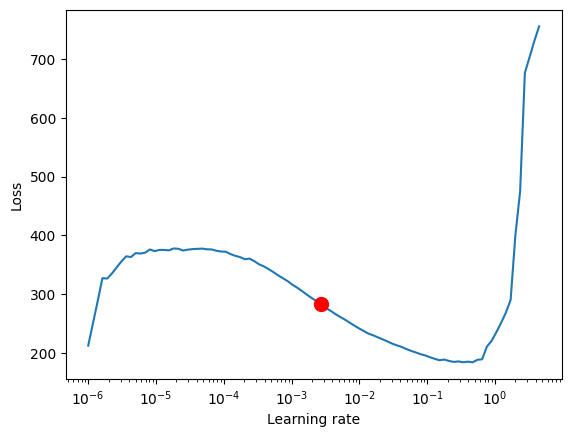

C:\Users\wtdme\AppData\Local\Temp\ipykernel_10500\917049476.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [21]:
res = trainer.tuner.lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [22]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=100,
    gpus=0,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=res.suggestion(),
    hidden_size=64,
    attention_head_size=4,
    dropout=0.2,
    hidden_continuous_size=32,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss([0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 0.99]),
    log_interval=10, 
    reduce_on_plateau_patience=4,
    optimizer='adam'
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 355.9k


In [23]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 768   
4  | static_variable_selection          | VariableSelectionNetwork        | 13.6 K
5  | encoder_variable_selection         | VariableSelectionNetwork        | 71.4 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 64.0 K
7  | static_context_variable_selection  | GatedResidualNetwork            | 16.8 K
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 16.8 K
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 16.8

Epoch 20: 100%|██████████| 7/7 [00:01<00:00,  5.52it/s, loss=18.8, v_num=2, train_loss_step=18.10, val_loss=69.80, train_loss_epoch=18.10]


In [46]:
 ## HyperParamter Tuning
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study CAPTION: IT TOOK REALLY LONG TIME
# Optuna
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=500,
    max_epochs=1000,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 512),
    hidden_continuous_size_range=(8, 512),
    attention_head_size_range=(1, 8),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

[I 2023-03-13 00:38:50,882] A new study created in memory with name: no-name-b7706c24-57e9-41dd-a701-cc45f59ce80a
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\wtdme\anaconda3\lib\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
c:\Users\wtdme\anaconda3\lib\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
c:\Users\wtdme\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dat

In [24]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
# best_model_path = trainer.checkpoint_callback.best_model_path
# best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
best_tft = tft

In [25]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(nan)

In [26]:
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

In [27]:
raw_predictions  # 각 quantile에 raw 값

Output(prediction=tensor([[[2214.8940, 2242.0806, 2325.1785, 2385.4668, 2367.8989, 2431.0698,
          2432.5137],
         [2213.5818, 2256.4214, 2327.2529, 2384.6350, 2368.6907, 2436.2334,
          2439.7651],
         [2108.4253, 2137.9448, 2183.2222, 2248.1509, 2213.5249, 2311.6902,
          2276.3760],
         [2203.7886, 2235.3474, 2287.6150, 2346.2659, 2316.7258, 2422.1206,
          2403.1035],
         [2244.8213, 2284.5884, 2351.7625, 2408.7112, 2386.3872, 2479.3479,
          2477.5679],
         [2079.0789, 2130.5459, 2177.9941, 2246.5120, 2203.3770, 2302.0103,
          2288.3525]],

        [[2212.5337, 2239.5518, 2322.3220, 2382.5730, 2365.3374, 2427.7422,
          2428.7080],
         [2211.5098, 2254.1663, 2324.7803, 2382.0691, 2366.4136, 2433.2803,
          2436.2944],
         [2106.5183, 2136.0549, 2181.1367, 2245.8679, 2211.5603, 2309.2107,
          2273.1609],
         [2202.2903, 2233.6609, 2285.8403, 2344.3259, 2315.1216, 2419.9321,
          2400.4419],


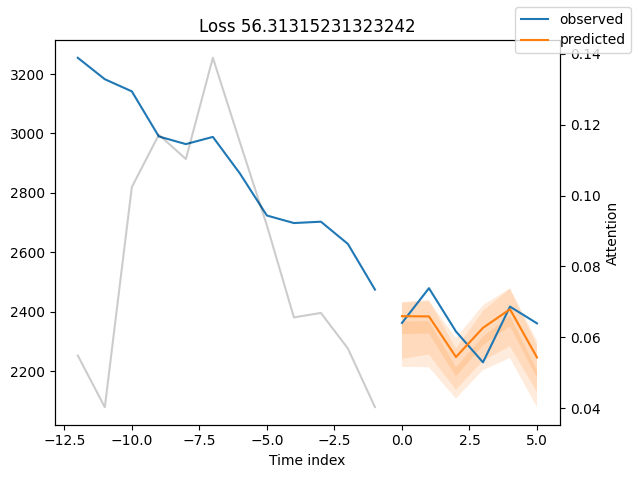

In [28]:
best_tft.plot_prediction(x, raw_predictions, idx=0, add_loss_to_title=True);

In [29]:
# help(best_tft.plot_prediction)

In [30]:
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

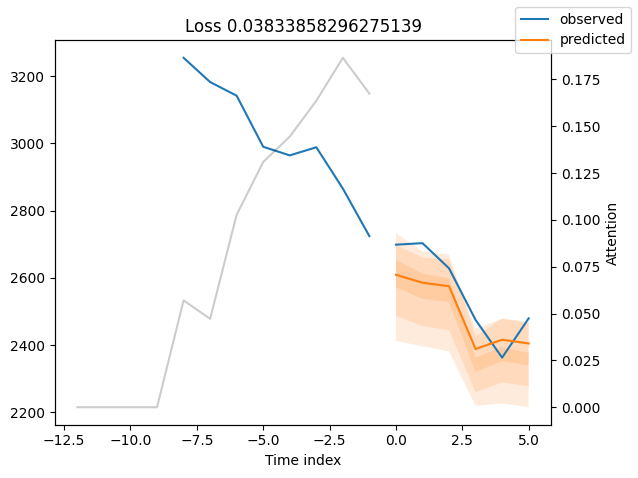

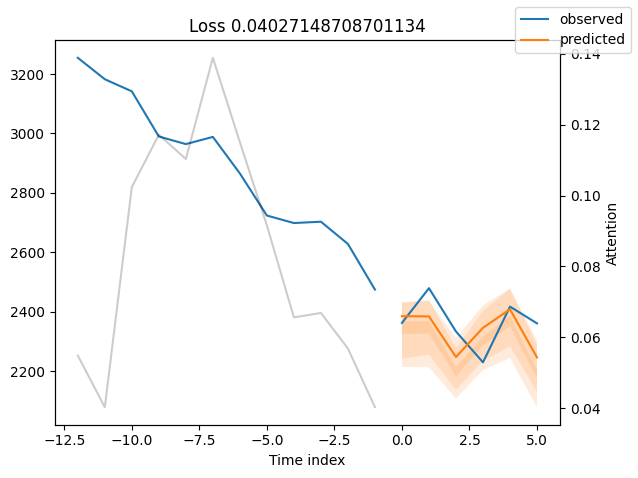

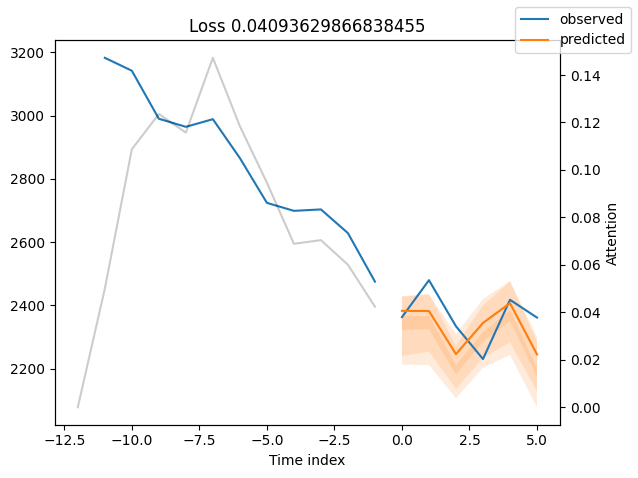

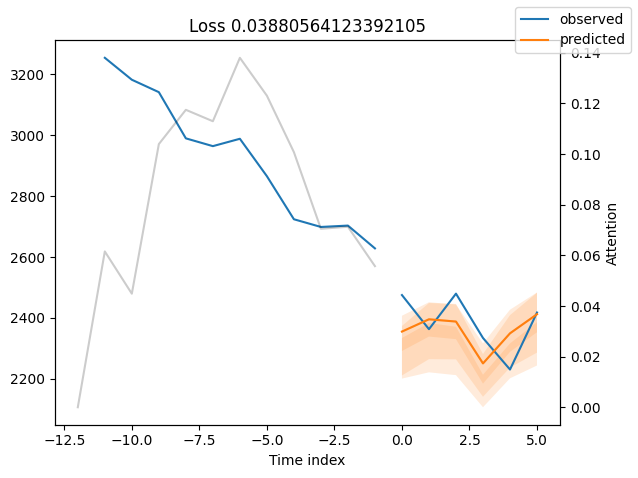

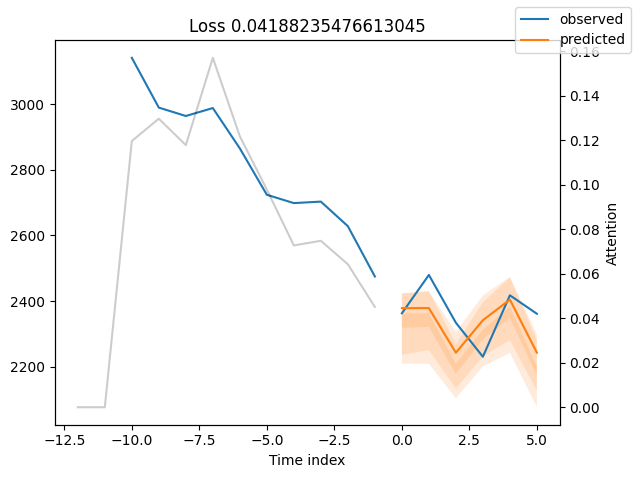

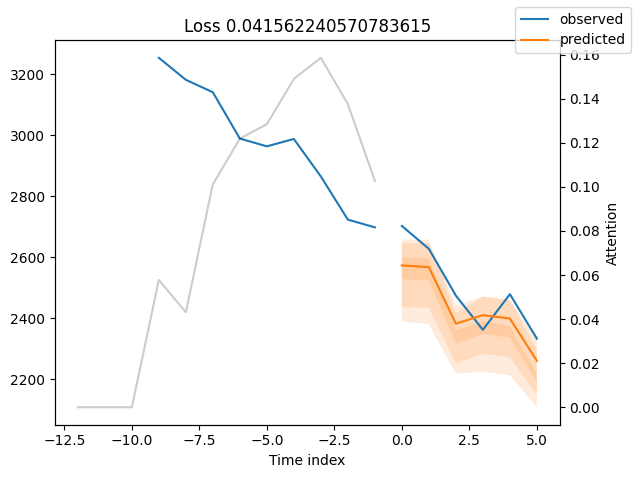

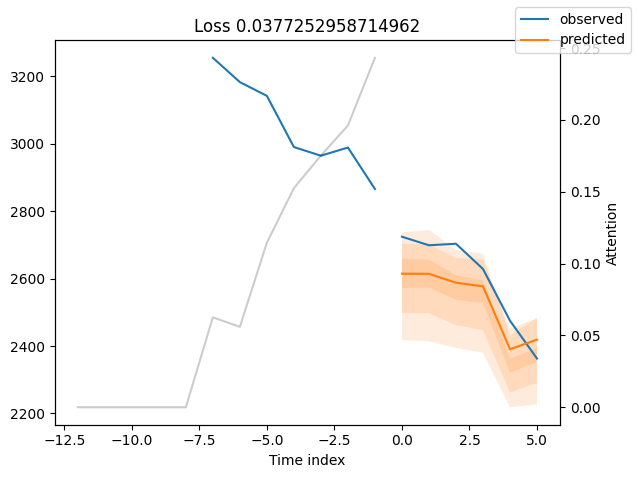

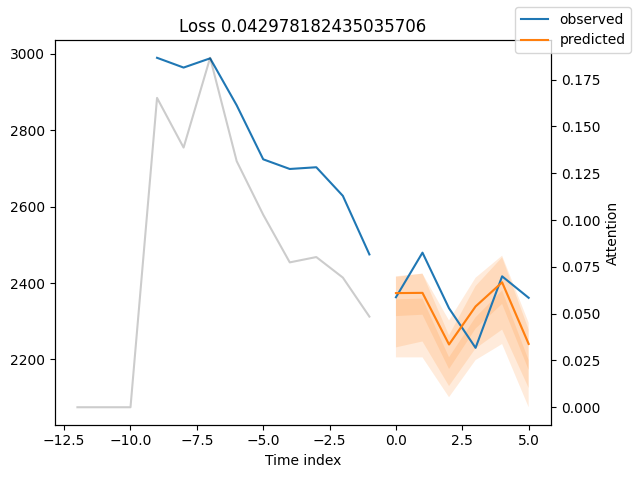

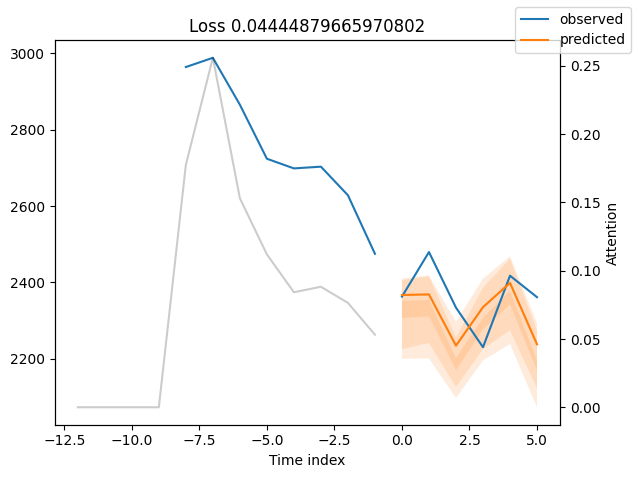

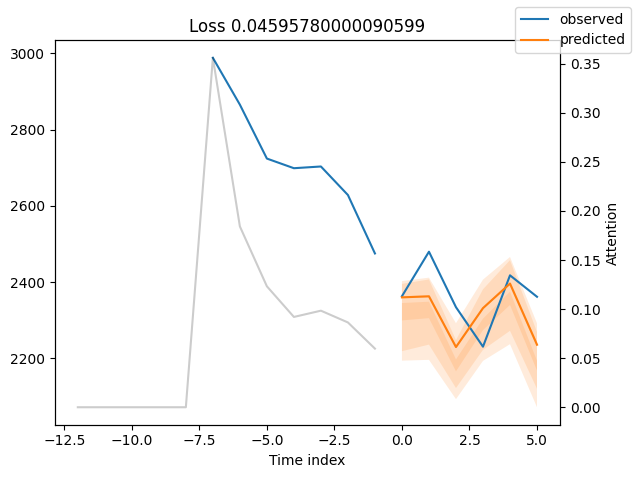

In [31]:
predictions = best_tft.predict(val_dataloader)
mean_losses = SMAPE(reduction="none")(predictions, actuals).mean(1)
indices = mean_losses.argsort(descending=False)  # sort losses
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(
        x, raw_predictions, idx=indices[idx], add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles)
    );

c:\Users\wtdme\anaconda3\envs\torch\lib\site-packages\pytorch_forecasting\models\base_model.py:1699: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  log_scale = scipy.stats.skew(values_actual) > 1.6
c:\Users\wtdme\anaconda3\envs\torch\lib\site-packages\pytorch_forecasting\models\base_model.py:1699: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  log_scale = scipy.stats.skew(values_actual) > 1.6
c:\Users\wtdme\anaconda3\envs\torch\lib\site-packages\pytorch_forecasting\models\base_model.py:1699: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  log_scale = scipy.stats.skew(values_actual) > 1.6


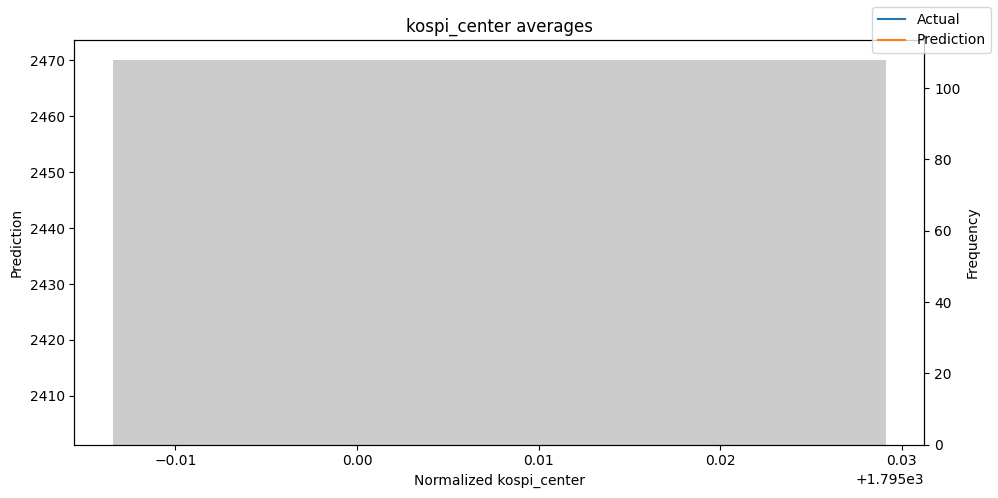

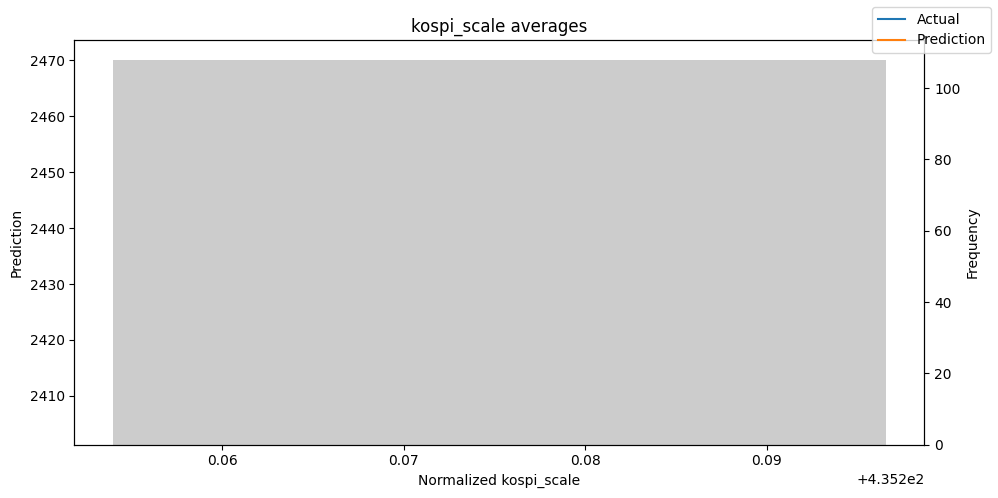

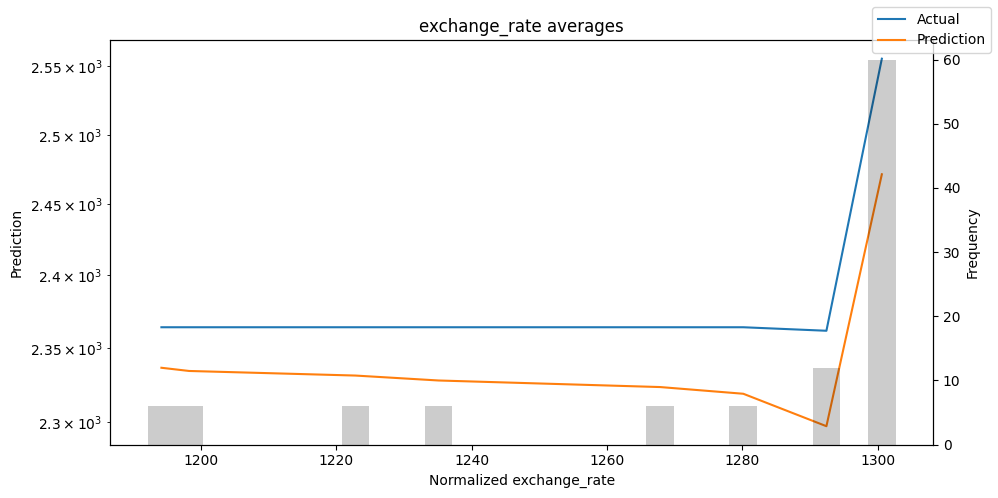

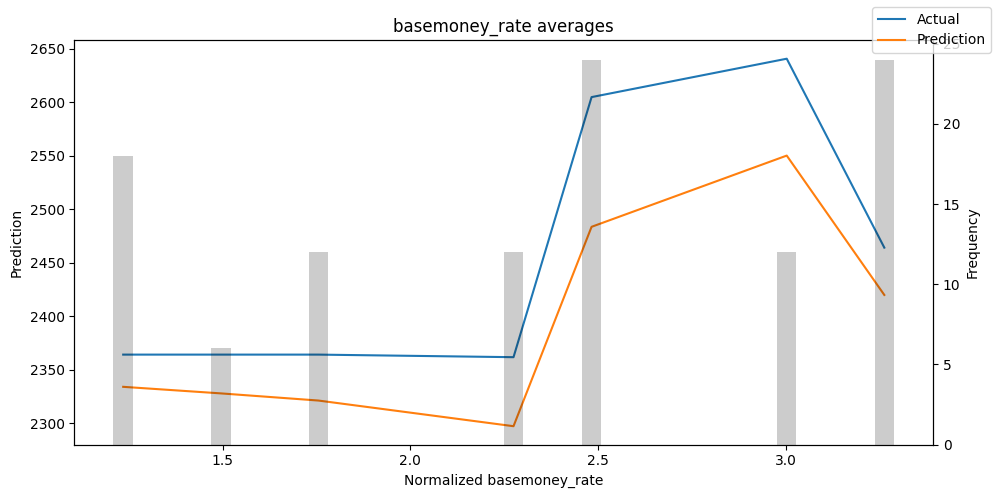

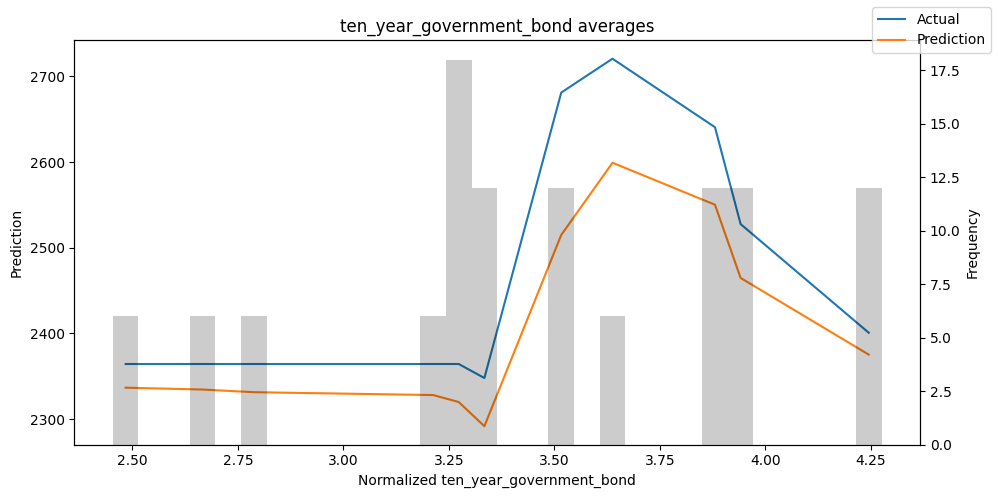

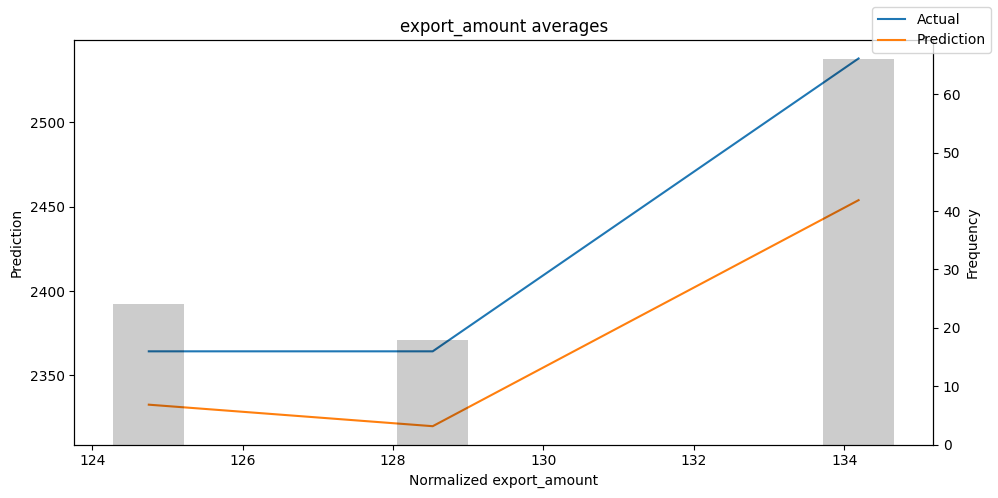

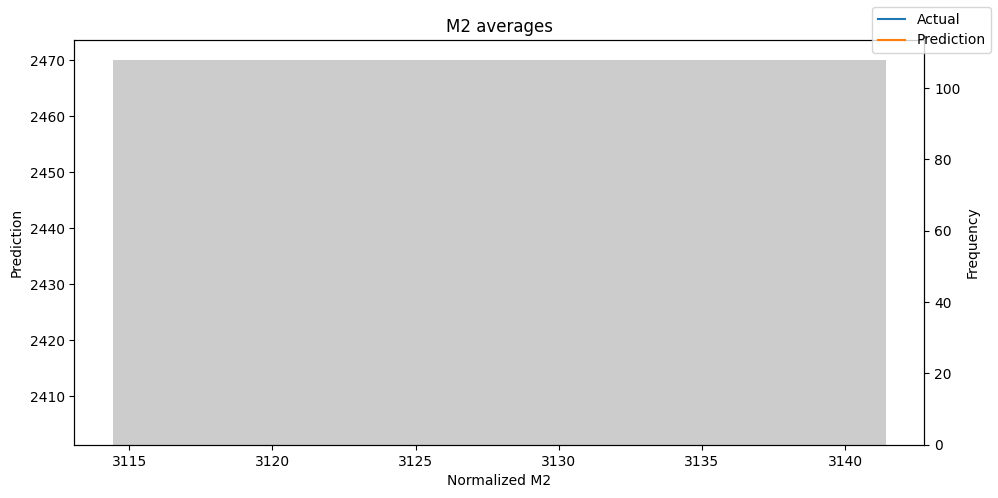

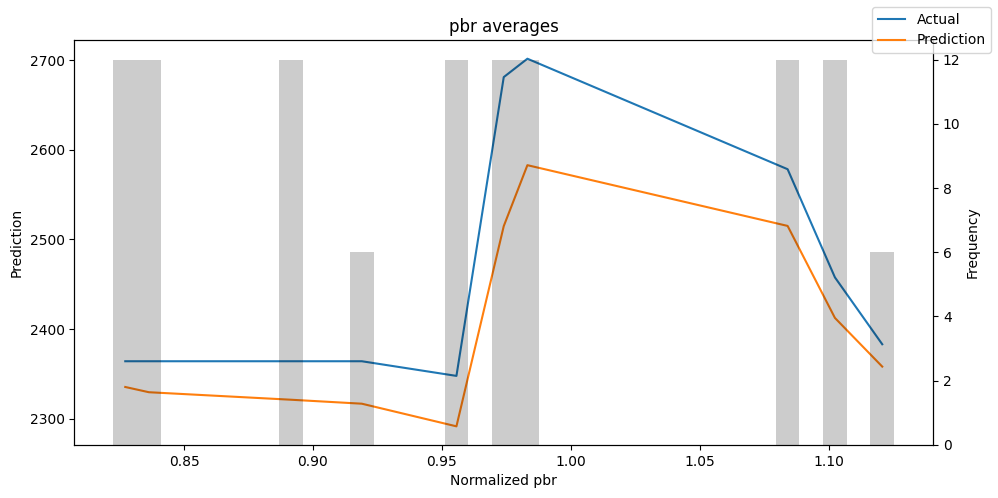

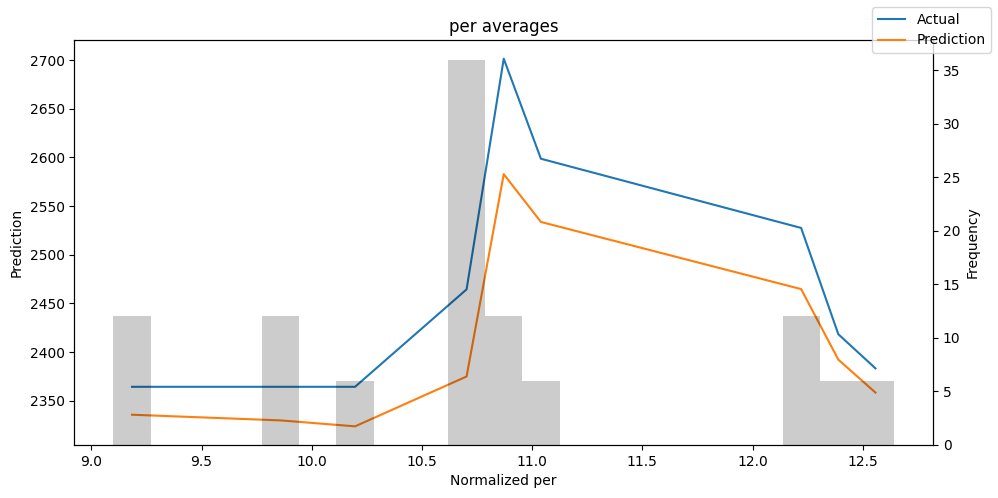

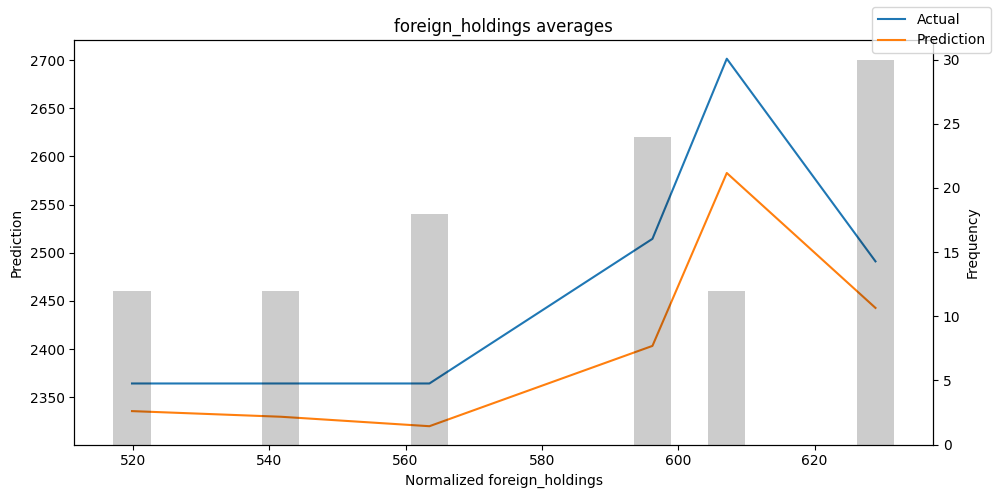

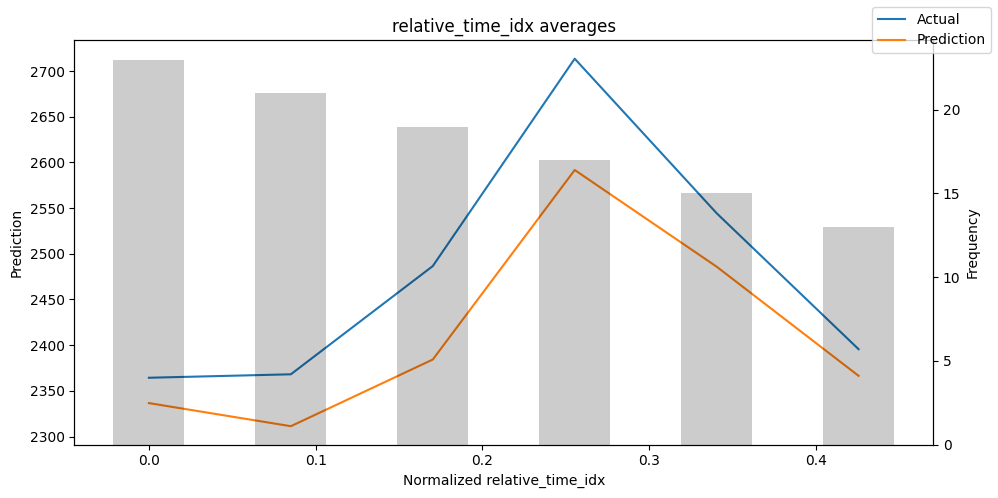

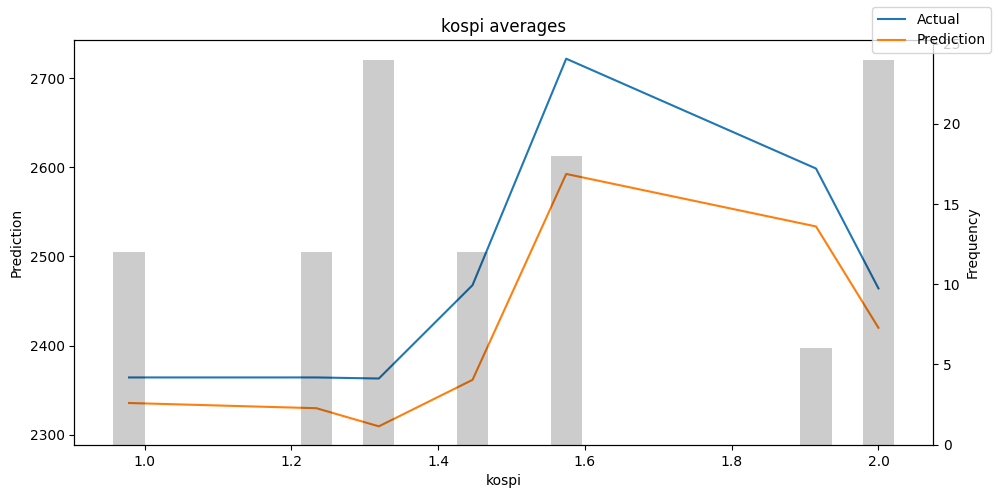

In [32]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

In [33]:
# 1 x n_timesteps x n_quantiles = 1 x 6 x 7
best_tft.predict(
    training,
    mode="quantiles",
)

tensor([[[ 769.8839,  855.9769,  892.8785,  ...,  923.1816,  988.9010,
          1064.5425],
         [ 828.6566,  912.3303,  956.8717,  ...,  992.1931, 1047.7134,
          1128.8862],
         [ 815.9467,  902.8531,  953.4858,  ...,  986.2446, 1037.7537,
          1109.0461],
         [ 769.2499,  873.4134,  909.1126,  ...,  932.3606,  982.0015,
          1012.0629],
         [ 796.1948,  894.8714,  939.0634,  ...,  967.3326, 1010.2027,
          1041.8060],
         [ 815.0444,  913.7949,  963.0978,  ...,  996.2922, 1035.3378,
          1066.9248]],

        [[ 825.2400,  914.5404,  953.9272,  ...,  991.9087, 1053.0117,
          1135.8389],
         [ 816.1918,  900.2106,  951.4531,  ...,  984.0455, 1039.3324,
          1110.8042],
         [ 771.1677,  871.8804,  909.5543,  ...,  931.8277,  983.8407,
          1012.8021],
         [ 800.0917,  895.9627,  941.8900,  ...,  968.9881, 1013.8354,
          1043.3313],
         [ 820.5051,  917.2291,  967.8311,  ...,  999.9371, 1040.561

c:\Users\wtdme\anaconda3\envs\torch\lib\site-packages\pytorch_forecasting\models\base_model.py:92: UserWarning: Not all dimensions are equal for tensors shapes. Example tensor torch.Size([64, 6, 4, 12]). Returning list instead of torch.Tensor.
  warnings.warn(


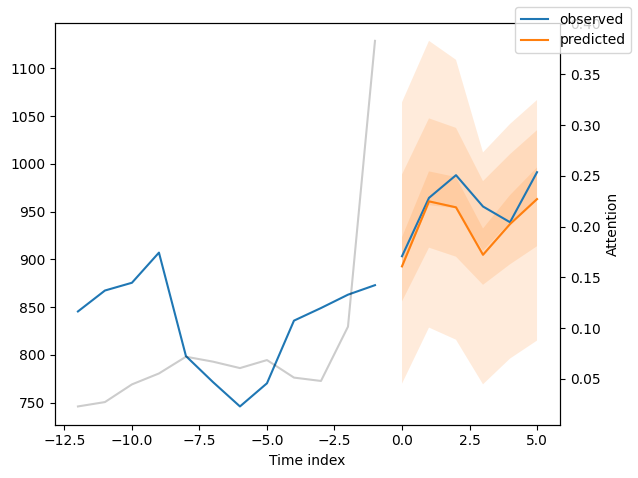

In [34]:
raw_prediction, x = best_tft.predict(
    training,
    mode="raw",
    return_x=True,
)
best_tft.plot_prediction(x, raw_prediction, idx=0);

In [35]:
# help(best_tft.plot_prediction)

#### 미래예측

In [36]:
# raw_prediction = best_tft.predict(
#     validation,
#     mode="raw",
#     return_x=False,

# best_tft.plot_prediction(x, raw_prediction, idx=0);
# best_tft.plot_prediction(out=raw_prediction, idx=0);

In [37]:
# raw_prediction.prediction.numpy().shape

In [38]:
# help(best_tft.interpret_output)  # attention weigth

#### 중요도

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x250 with 1 Axes>,
 'encoder_variables': <Figure size 700x450 with 1 Axes>,
 'decoder_variables': <Figure size 700x425 with 1 Axes>}

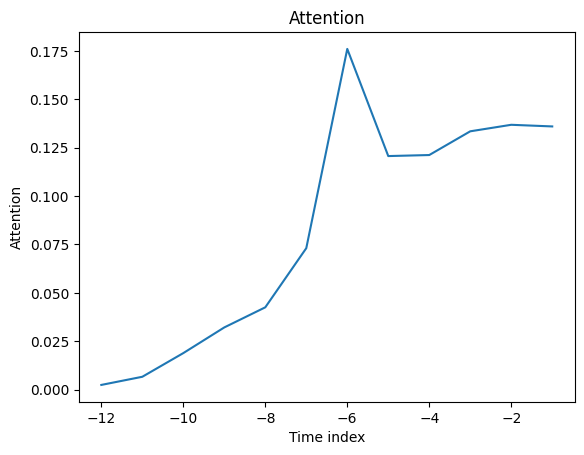

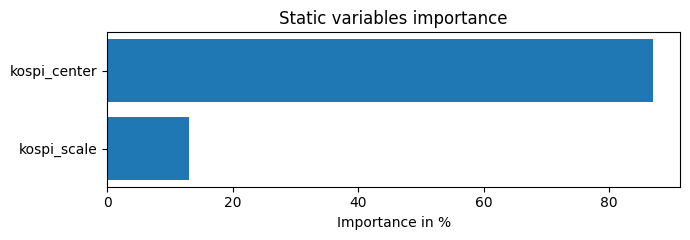

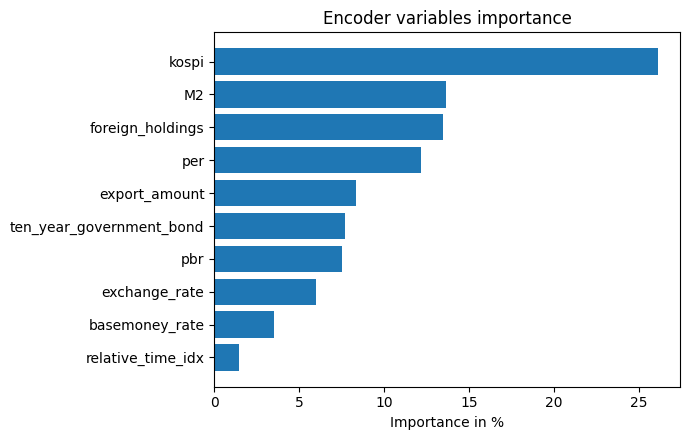

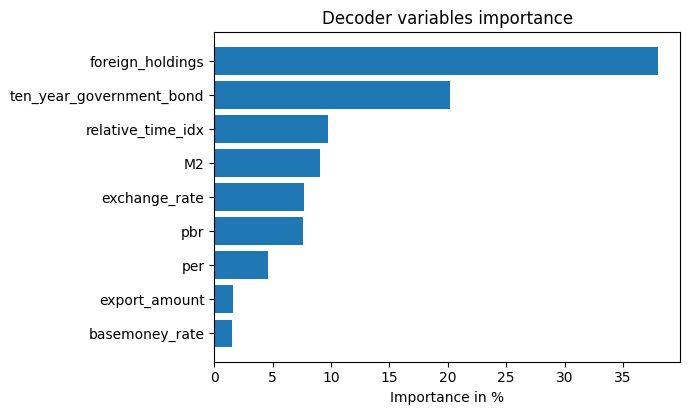

In [39]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)